## Importa módulos

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cx_Oracle
import pandas as pd
import numpy as np
import logging
import json
import itertools
import _pickle as cPickle
from IPython.core.debugger import Tracer
from functools import reduce
import operator
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from multiprocessing import Pool
import os
from sklearn.metrics import confusion_matrix
from classificadores import regex
import dask.dataframe as ddf
from dask.delayed import delayed
from multiprocessing import cpu_count

## Variáveis de configuração

In [2]:
DS_EXADATA_HOST=os.environ['DB_HOST']
DS_EXADATA_PORT=os.environ['DB_PORT']
DS_EXADATA_SID=os.environ['DB_SID']
DS_EXADATA_user=os.environ['DB_USER']
DS_EXADATA_password=os.environ['DB_PASSWORD']

pd.set_option('display.max_colwidth', 300)
CACHE=True

## Conexão com banco

In [3]:
if not CACHE:
    dsn_tns = cx_Oracle.makedsn(
            DS_EXADATA_HOST,
            DS_EXADATA_PORT,
            DS_EXADATA_SID)
    ora_conn = cx_Oracle.connect(
            DS_EXADATA_user,
            DS_EXADATA_password,
            dsn_tns,
            encoding="UTF-8",
            nencoding="UTF-8",
            threaded=True)

## Query dos processos

#### Extrai os valores do cx_Oracle.LOB, processo lento e pouco paralelizável
#### Altere a variável CACHE para utilizar um pickle armazenado anteriormente

In [4]:
if CACHE:
    %time df_ora = pd.read_pickle('df_ora_lido.pkl')
else:
    df_ora = pd.read_sql("""SELECT TJRJ_PROCESSO_MOVIMENTO_TJ.*, 0 as EH_SENTENCA 
     FROM tjrj.TJRJ_PROCESSO_MOVIMENTO_TJ 
     WHERE PRMV_TX_INTEIRO_TEOR IS NOT NULL
     and PRMV_TP_MOVIMENTO is not null""", con=ora_conn)

    %time df_ora['PRMV_TX_INTEIRO_TEOR'] = df_ora.PRMV_TX_INTEIRO_TEOR.apply(lambda x: x.read())
    
    df_ora.loc[df_ora.PRMV_TP_MOVIMENTO.str.contains('sentença', case=False), 'EH_SENTENCA'] = 1
    df_ora['resultado_classificacao'] = 0
    
    df_ora.to_pickle('df_ora_lido.pkl')

CPU times: user 268 ms, sys: 99.8 ms, total: 368 ms
Wall time: 367 ms


# Classificação dos documentos

### 1 Define Matriz de confusão

In [5]:
from collections import namedtuple

MatrizConfusao = namedtuple('MatrizConfusao', ['acuracia', 'sensibilidade', 'especificidade'])

def matrix_de_confusao(corretos, classificados):
    n = len(corretos)
    classificados_corretamentes = sum(corretos == classificados)
    acuracia = classificados_corretamentes / n * 100
    
    sensibilidade = (sum(np.logical_and(classificados == 1, corretos == 1)) 
                     / sum(corretos == 1)) * 100
    especificidade = (sum(np.logical_and(classificados == 0, corretos == 0)) 
                     / sum(corretos == 0)) * 100
    
    
    return MatrizConfusao(acuracia, sensibilidade, especificidade)


def _verifica_resultado(resultado):
    return resultado['positivo']

#### Aplica classificadores em paralelo

In [6]:
def classifica(item):
    return _verifica_resultado(regex.classifica_item(item))
        
def classifica_unico(item):
    retorno = regex.classifica_item(item)
    saida = []
    for chave in retorno['classificacoes']:
        saida += [
            retorno['classificacoes'][chave]['positivo']            
        ]
    return saida

colunas_classificadores = [x.__name__ for x in regex.classificadores]
    
def tempo():
    global df_ora
    with Pool(cpu_count()) as pool:
        resultado = pool.map(
            classifica_unico,
            df_ora.PRMV_TX_INTEIRO_TEOR.values)
        df_ora = df_ora
        df_ora = pd.concat([df_ora, pd.DataFrame(resultado, columns=colunas_classificadores)], axis=1)
        df_ora['CLASSIFICACAO'] = np.sum(df_ora[colunas_classificadores].values, axis=1) >=1
        
tempo()

In [7]:
df_ora

,PRMV_DK,PRMV_PRTJ_DK,PRMV_TP_MOVIMENTO,PRMV_DT_ULTIMA_ATUALIZACAO,PRMV_HASH,PRMV_TX_INTEIRO_TEOR,EH_SENTENCA,ProcedenteClassifier,ImprocedenteClassifier,ParcialmenteProcedenteClassifier,...,AbsolvoClassifier,NegacaoProvimentoClassifier,DeixoResolverMeritoClassifier,DaProvimentoClassifier,IndeferenciaClassifier,ArquivamentoClassifier,ExtincaoProcessoClassifier,ExtincaoComResolucaoClassifier,ExtincaoSemResolucaoClassifier,CLASSIFICACAO
0,5638,119,Sentença em Audiência - Julgado procedente o pedido,2018-04-11 16:55:07,23e71b42aa4969cf2af1943d78f635d5,"Em 28 de maio de 2013, às 13:45 horas na sala de audiências deste Juízo, perante o MM. Juiz, Dr. SANDRO PITTHAN ESPINDOLA, e a Dra. Paula Marques da Silva Oliveira, Promotora de Justiça da Infância e Juventude, realizou-se a audiência designada. Feito o pregão, presentes o requerente, genitora d...",1,False,False,False,...,False,False,True,False,False,False,False,False,False,True
1,5641,119,Audiência Especial,2018-04-11 16:55:07,32b2b1835d91e16e3f356bc8ac45e223,"Em 28 de maio de 2013, às 13:45 horas na sala de audiências deste Juízo, perante o MM. Juiz, Dr. SANDRO PITTHAN ESPINDOLA, e a Dra. Paula Marques da Silva Oliveira, Promotora de Justiça da Infância e Juventude, realizou-se a audiência designada. Feito o pregão, presentes o requerente, genitora d...",0,False,False,False,...,False,False,True,False,False,False,False,False,False,True
2,5648,119,Decisão - Deferimento de Medidas Protetivas de Urgência,2018-04-11 16:55:07,5966c2a95ffbd5049a729d56530ee9e2,"Recebo a emenda de fl. 32.\r\nAnote-se onde couber.\r\nTrata-se de adoção unilateral com estudos favoráveis. \r\nDesigna-se o dia 28/05/2013, às 13h30min, para a audiência prevista no art. 166 §§ 1º e 3º do ECA.\r\nI-se, devendo a requerente comparecer com a adoltanda.\r\nDê-se ciência ao MP.",0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,5661,119,Decisão - Decisão Determinação,2018-04-11 16:55:07,5377cb2c5447c08dacc55c1a7e2d2416,"Para a realização do Estudo Psicológico nomeio como Perita a Psicóloga ISABEL LACERDA, cadastrada pelo DIPEJ.\r\nApós a apresentação do Laudo, oficie-se ao DIPEJ, conforme Resolução n° 20 de 14/09/2006 do Conselho da Magistratura.",0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,5668,119,Decisão - Decisão Determinação,2018-04-11 16:55:07,13611203e365267074e6d3afb8649969,"Decisão\r\n\r\nIntimem-se os requerentes para que emendem a inicial, excluindo a genitora do pólo ativo do processo e acrescentando o sobrenome a ser atribuído à criança.\r\n\r\nIntimem-se, ainda, para cumprimento do ítem 3 da promoção ministerial.\r\n\r\nO art. 141, §2º da Lei Federal nº 8.069/...",0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,5674,119,Despacho - Proferido despacho de mero expediente,2018-04-11 16:55:07,84ecdd1c7ebe44793ee354f432ca1a27,"Abra-se vista ao Ministério Público.\r\n\r\nApós, ao Juiz auxiliar responsável pelo processo, de acordo com a numeração e ordem de serviço.",0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,5684,119,Despacho - Proferido despacho de mero expediente,2018-04-11 16:55:07,9556fd6ab8b2c2b3974c805babb45e67,"Trata-se de pedido de adoção de menor deduzido pelo padastro, com o qual concorda a genitora, sendo certo que no registro de nascimento não consta o nome do pai biológico. \r\nAssim, considerando o disposto no art. 92, IX, do Codjerj, DECLINO da competência para a Vara da Infância Juventude e Id...",0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,5690,119,Despacho - Proferido despacho de mero expediente,2018-04-11 16:55:07,48820201f6ac17e52e7a8401c66eb605,"1) A fim de ser apreciado o pedido de gratuidade de justiça venham cópias das três últimas declarações de renda feitas à SRF, completas.\r\n2) Venha afirmação de hipossuficiência nos termos da Lei 1.060/50.\r\n3) Trata-se de pedido de adoção, art. 1

In [80]:
def plota_matriz_confusao(cm, axis, normalizado):
    texto = '%.2f%%' if normalizado else '%d'
    axis.imshow(cm, cmap=plt.cm.Blues)
    axis.set_xlabel('Predito', fontsize=14)
    axis.set_ylabel('Metadado TJ', fontsize=14)
    thresh = cm.max() / 2.
    axis.set_xticks([0, 1])
    axis.set_yticks([-0, 1])
    axis.set_xticklabels(['Neg', 'Pos'], fontsize=14)
    axis.set_yticklabels(['Neg', 'Pos'], fontsize=14)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        axis.text(j, i, texto % cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=13)

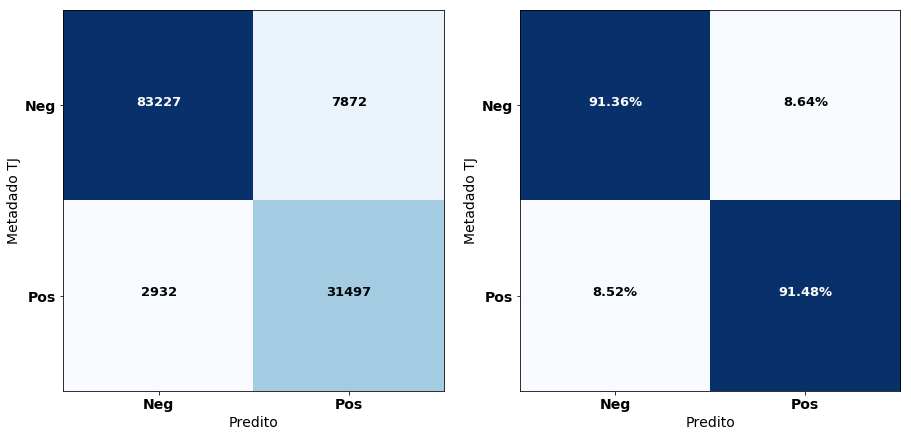

In [81]:
plt.rcParams['font.weight'] = 'bold'
cm = confusion_matrix(df_ora.EH_SENTENCA.values, df_ora.CLASSIFICACAO.values, labels=[0, 1])
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
fig, (ax1, ax2) = plt.subplots(1, 2)
plota_matriz_confusao(cm, ax1, False)
plota_matriz_confusao(cmn, ax2, True)
fig.set_size_inches(15, 8)


Ideias:

1. Aplicar auto corretor no texto para um catálogo de palávras pré-definido, ie.:
    PROCENTE -> PROCEDENTE
2. Tentar excluir parágrafos iniciais da análise, ie.: primeiros 30%
3. Criar um dicionário de palavras soletradas e remover os espaços em branco das sentenças


### Log de Rultados

#### 20/04/2018
![https://github.com/MinisterioPublicoRJ/classificador-lyra-notebooks/raw/master/df_ora-01.png](https://github.com/MinisterioPublicoRJ/classificador-lyra-notebooks/raw/master/df_ora-01.png)


#### 24/04/2018
![https://github.com/MinisterioPublicoRJ/classificador-lyra-notebooks/raw/master/df_ora-02.png](https://github.com/MinisterioPublicoRJ/classificador-lyra-notebooks/raw/master/df_ora-02.png)

#### 26/04/2018
![https://github.com/MinisterioPublicoRJ/classificador-lyra-notebooks/raw/master/df_ora-03.png](https://github.com/MinisterioPublicoRJ/classificador-lyra-notebooks/raw/master/df_ora-03.png)


#### 26/04/2018
![https://github.com/MinisterioPublicoRJ/classificador-lyra-notebooks/raw/master/df_ora-04.png](https://github.com/MinisterioPublicoRJ/classificador-lyra-notebooks/raw/master/df_ora-04.png)


In [82]:
CHECKPOINT = False
if CHECKPOINT:
        fig.savefig('df_ora-04.png')
        df_ora.to_pickle('df_ora-04.pkl')